## Fundamental imports, agents assessment and submission functions

In [44]:
import numpy as np
import random
import time
import inspect
import os
from kaggle_environments import make, evaluate, utils

# Create the game environment
# Set debug=True to see the errors if your agent refuses to run
env = make("connectx", debug=True)

# List of available default agents
print(list(env.agents))


def get_win_percentages(agent1, agent2, n_rounds=100):
    # Use default Connect Four setup
    config = {'rows': 6, 'columns': 7, 'inarow': 4}
    # Agent 1 goes first (roughly) half the time          
    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    # Agent 2 goes first (roughly) half the time      
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))
    


def write_agent_to_file(function, file):
    with open(file, "a" if os.path.exists(file) else "w") as f:
        f.write(inspect.getsource(function))
        print(function, "written to", file)

['random', 'negamax']


# Loading previously developed agents - Classic Agents

In [46]:
from submission_test import my_agent_test as level_two_agent
from submission_one_step_agent import my_agent_one_step_5_heuristic as one_step_agent
from submission_alphabeta_agent_with_improved_heuristics_three_step import alphabeta_agent_with_improved_heuristics as three_step_agent

In [47]:
t = time.time()
get_win_percentages(level_two_agent, one_step_agent, n_rounds=1)
delta = time.time() - t
print(delta)

Agent 1 Win Percentage: 0.0
Agent 2 Win Percentage: 1.0
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0
0.9419407844543457


In [48]:
t = time.time()
get_win_percentages(three_step_agent, one_step_agent, n_rounds=1)
delta = time.time() - t
print(delta)

Agent 1 Win Percentage: 1.0
Agent 2 Win Percentage: 0.0
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0
9.665860891342163


# Reinforcement Learning

In [49]:
#!pip install 'tensorflow==1.15.0'

In [50]:
import tensorflow as tf

In [51]:
tf.__version__

'1.15.0'

In [21]:
#!pip install gym

In [52]:
from gym import spaces

class ConnectFourGym:
    def __init__(self, agent2="random"):
        ks_env = make("connectx", debug=True)
        self.env = ks_env.train([None, agent2])
        self.rows = ks_env.configuration.rows
        self.columns = ks_env.configuration.columns
        # Learn about spaces here: http://gym.openai.com/docs/#spaces
        self.action_space = spaces.Discrete(self.columns)
        self.observation_space = spaces.Box(low=0, high=2, 
                                            shape=(self.rows,self.columns,1), dtype=np.int)
        # Tuple corresponding to the min and max possible rewards
        self.reward_range = (-10, 1)
        # StableBaselines throws error if these are not defined
        self.spec = None
        self.metadata = None
    def reset(self):
        self.obs = self.env.reset()
        return np.array(self.obs['board']).reshape(self.rows,self.columns,1)
    def change_reward(self, old_reward, done):
        if old_reward == 1: # The agent won the game
            return 1
        elif done: # The opponent won the game
            return -1
        else: # Reward 1/42
            return 1/(self.rows*self.columns)
    def step(self, action):
        # Check if agent's move is valid
        is_valid = (self.obs['board'][int(action)] == 0)
        if is_valid: # Play the move
            self.obs, old_reward, done, _ = self.env.step(int(action))
            reward = self.change_reward(old_reward, done)
        else: # End the game and penalize agent
            reward, done, _ = -10, True, {}
        return np.array(self.obs['board']).reshape(self.rows,self.columns,1), reward, done, _


In [53]:
# Create ConnectFour environment
env = ConnectFourGym(agent2='random')

In [24]:
#!brew install cmake openmpi

In [25]:
#!pip install stable-baselines

In [54]:
import stable_baselines

stable_baselines.__version__

'2.9.0'

In [55]:
#!pip install mpi4py

In [56]:
import os
from stable_baselines.bench import Monitor 
from stable_baselines.common.vec_env import DummyVecEnv

# Create directory for logging training information
log_dir = "ppo/"
os.makedirs(log_dir, exist_ok=True)

# Logging progress
monitor_env = Monitor(env, log_dir, allow_early_resets=True)

# Create a vectorized environment
vec_env = DummyVecEnv([lambda: monitor_env])

In [57]:
from stable_baselines import PPO1 
from stable_baselines.a2c.utils import conv, linear, conv_to_fc
from stable_baselines.common.policies import CnnPolicy

# Neural network for predicting action values
def modified_cnn(scaled_images, **kwargs):
    activ = tf.nn.relu
    layer_1 = activ(conv(scaled_images, 'c1', n_filters=32, filter_size=3, stride=1, 
                         init_scale=np.sqrt(2), **kwargs))
    layer_2 = activ(conv(layer_1, 'c2', n_filters=64, filter_size=3, stride=1, 
                         init_scale=np.sqrt(2), **kwargs))
    layer_2 = conv_to_fc(layer_2)
    return activ(linear(layer_2, 'fc1', n_hidden=512, init_scale=np.sqrt(2)))  

class CustomCnnPolicy(CnnPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomCnnPolicy, self).__init__(*args, **kwargs, cnn_extractor=modified_cnn)
        
# Initialize agent
model = PPO1(CustomCnnPolicy, vec_env, verbose=0)

343.3762309551239


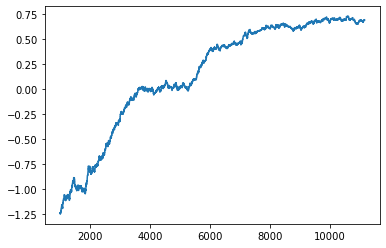

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# Train agent
t = time.time()
model.learn(total_timesteps=100_000)
delta = time.time() - t
print(delta)

# Plot cumulative reward
with open(os.path.join(log_dir, "monitor.csv"), 'rt') as fh:    
    firstline = fh.readline()
    assert firstline[0] == '#'
    df = pd.read_csv(fh, index_col=None)['r']
df.rolling(window=1000).mean().plot()
plt.show()

In [60]:
def agent1(obs, config):
    #with open('history', mode='a') as file:
    #file.write(f'\n    data = {learner.policy._get_data()}\n')
        #file.write(f'    obs = {obs}\n config={config}')
    # Use the best model to select a column
    col, _ = model.predict(np.array(obs['board']).reshape(6,7,1))
    # Check if selected column is valid
    is_valid = (obs['board'][int(col)] == 0)
    # If not valid, select random move. 
    if is_valid:
        return int(col)
    else:
        return random.choice([col for col in range(config.columns) if obs.board[int(col)] == 0])

In [63]:
t = time.time()
get_win_percentages('negamax', agent1, n_rounds=10)
delta = time.time() - t
print(delta)

Agent 1 Win Percentage: 0.9
Agent 2 Win Percentage: 0.1
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0
7.336079120635986


In [64]:
test_list = model.get_parameters()

In [65]:
test_list.keys()

odict_keys(['model/c1/w:0', 'model/c1/b:0', 'model/c2/w:0', 'model/c2/b:0', 'model/fc1/w:0', 'model/fc1/b:0', 'model/vf/w:0', 'model/vf/b:0', 'model/pi/w:0', 'model/pi/b:0', 'model/q/w:0', 'model/q/b:0'])

In [66]:
%%writefile RL_test_submission.py
def RL_test_agent(obs, config):
    
    import numpy as np
    import tensorflow as tf
    from stable_baselines import PPO1 
    from stable_baselines.a2c.utils import conv, linear, conv_to_fc
    from stable_baselines.common.policies import CnnPolicy
    from kaggle_environments import evaluate, make, utils
    from gym import spaces
    array = np.array
    float32 = np.float32

    class ConnectFourGym:
        def __init__(self, agent2="random"):
            ks_env = make("connectx", debug=True)
            self.env = ks_env.train([None, agent2])
            self.rows = ks_env.configuration.rows
            self.columns = ks_env.configuration.columns
            # Learn about spaces here: http://gym.openai.com/docs/#spaces
            self.action_space = spaces.Discrete(self.columns)
            self.observation_space = spaces.Box(low=0, high=2, 
                                                shape=(self.rows,self.columns,1), dtype=np.int)
            # Tuple corresponding to the min and max possible rewards
            self.reward_range = (-10, 1)
            # StableBaselines throws error if these are not defined
            self.spec = None
            self.metadata = None
        def reset(self):
            self.obs = self.env.reset()
            return np.array(self.obs['board']).reshape(self.rows,self.columns,1)
        def change_reward(self, old_reward, done):
            if old_reward == 1: # The agent won the game
                return 1
            elif done: # The opponent won the game
                return -1
            else: # Reward 1/42
                return 1/(self.rows*self.columns)
        def step(self, action):
            # Check if agent's move is valid
            is_valid = (self.obs['board'][int(action)] == 0)
            if is_valid: # Play the move
                self.obs, old_reward, done, _ = self.env.step(int(action))
                reward = self.change_reward(old_reward, done)
            else: # End the game and penalize agent
                reward, done, _ = -10, True, {}
            return np.array(self.obs['board']).reshape(self.rows,self.columns,1), reward, done, _
    
    # Neural network for predicting action values
    def modified_cnn(scaled_images, **kwargs):
        activ = tf.nn.relu
        layer_1 = activ(conv(scaled_images, 'c1', n_filters=32, filter_size=3, stride=1, 
                             init_scale=np.sqrt(2), **kwargs))
        layer_2 = activ(conv(layer_1, 'c2', n_filters=64, filter_size=3, stride=1, 
                             init_scale=np.sqrt(2), **kwargs))
        layer_2 = conv_to_fc(layer_2)
        return activ(linear(layer_2, 'fc1', n_hidden=512, init_scale=np.sqrt(2)))  

    class CustomCnnPolicy(CnnPolicy):
        def __init__(self, *args, **kwargs):
            super(CustomCnnPolicy, self).__init__(*args, **kwargs, cnn_extractor=modified_cnn)

    

Overwriting RL_test_submission.py


In [67]:
np.set_printoptions(threshold=np.inf)

agent_path = 'RL_test_submission.py'

state_dict = model.get_parameters()

state_dict = {
    'model/c1/w:0': state_dict['model/c1/w:0'],
    'model/c1/b:0': state_dict['model/c1/b:0'],
    'model/c2/w:0': state_dict['model/c2/w:0'],
    'model/c2/b:0': state_dict['model/c2/b:0'],
    'model/fc1/w:0': state_dict['model/fc1/w:0'],
    'model/fc1/b:0': state_dict['model/fc1/b:0'],
    'model/vf/w:0': state_dict['model/vf/w:0'],
    'model/vf/b:0': state_dict['model/vf/b:0'],
    'model/pi/w:0': state_dict['model/pi/w:0'],
    'model/pi/b:0': state_dict['model/pi/b:0'],
    'model/q/w:0': state_dict['model/q/w:0'],
    'model/q/b:0': state_dict['model/q/b:0']
}

with open(agent_path, mode='a') as file:
    #file.write(f'\n    data = {learner.policy._get_data()}\n')
    file.write(f'    state_dict = {state_dict}\n')

In [68]:
%%writefile -a RL_test_submission.py
    
    # Create ConnectFour environment
    env = ConnectFourGym(agent2='random')

    # Initialize agent
    model = PPO1(CustomCnnPolicy, env, verbose=0)
    
    model.load_parameters(state_dict)
    col, _ = model.predict(np.array(obs['board']).reshape(6,7,1))
    # Check if selected column is valid
    is_valid = (obs['board'][int(col)] == 0)
    # If not valid, select random move. 
    if is_valid:
        return int(col)
    else:
        return random.choice([col for col in range(config.columns) if obs.board[int(col)] == 0])

Appending to RL_test_submission.py


In [69]:
from RL_test_submission import RL_test_agent as RL_agent

In [71]:
t = time.time()
get_win_percentages('random', RL_agent, n_rounds=10)
delta = time.time() - t
print(delta)

Agent 1 Win Percentage: 0.0
Agent 2 Win Percentage: 0.0
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 10
0.3256559371948242


In [29]:
from test_state_dict import get_state_dict

In [31]:
model.load_parameters(get_state_dict(), exact_match=True)

In [40]:
obs = {'board': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'mark': 1}
config={'episodeSteps': 1000, 'agentTimeout': 16, 'actTimeout': 8, 'runTimeout': 1200, 'isProduction': False, 'columns': 7, 'rows': 6, 'inarow': 4, 'timeout': 8}

In [70]:
RL_agent(obs, config)

NotImplementedError: Error: the model does not support input space of type NoneType